In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [2]:
class PatchTST(nn.Module):
    def __init__(self, seq_len, patch_len, stride, in_channels, d_model, nhead, num_layers, dim_feedforward, dropout=0.1):
        super().__init__()
        self.seq_len = seq_len
        self.patch_len = patch_len
        self.stride = stride
        self.in_channels = in_channels
        self.num_patches = (seq_len - patch_len) // stride + 1
        self.patch_dim = in_channels * patch_len

        self.proj = nn.Linear(self.patch_dim, d_model)
        self.pos_emb = nn.Parameter(torch.randn(1, self.num_patches, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Linear(d_model * self.num_patches, 1)

    def forward(self, x):
        # x: [B, seq_len, in_channels]
        B, L, C = x.shape
        x = x.permute(0,2,1)  # [B, C, L]
        patches = x.unfold(2, self.patch_len, self.stride)  # [B, C, num_patches, patch_len]
        patches = patches.contiguous().view(B, C, self.num_patches, self.patch_len)
        patches = patches.permute(0,2,1,3).reshape(B, self.num_patches, self.patch_dim)
        emb = self.proj(patches) + self.pos_emb
        out = self.encoder(emb)
        out = out.flatten(1)
        return self.head(out).squeeze(-1)

In [3]:
seq_len       = 24
patch_len     = 24
stride        = 24
in_channels   = 1
d_model       = 64
nhead         = 4
num_layers    = 2
dim_feedforward = 128
dropout       = 0.1
batch_size    = 64
epochs        = 50
lr            = 1e-3

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
df = pd.read_csv('Final_Train_Data.csv')

# unify column names if needed
df.columns = [c.strip() for c in df.columns]
if 'PV Output' in df.columns:
    df.rename(columns={'PV Output':'PV_Output'}, inplace=True)

# parse timestamp, drop bad rows
df['time'] = pd.to_datetime(df['time'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['time']).set_index('time').sort_index()

# ensure hourly index & fill gaps
df = df.resample('h').mean()
df['PV_Output'] = df['PV_Output'].interpolate(method='time')

print("Data range:", df.index.min(), "to", df.index.max())

series = df['PV_Output'].values.astype(np.float32)

Data range: 2019-01-01 00:00:00 to 2024-12-31 23:00:00


In [6]:
dates = df.index
start = dates[0]
train_end = start + pd.DateOffset(years=5) - pd.Timedelta(hours=1)
train_mask = dates <= train_end
y_train = series[train_mask]
y_test  = series[~train_mask]

In [7]:
def make_dataset(y):
    X, Y = [], []
    for i in range(len(y) - seq_len):
        X.append(y[i:i+seq_len])
        Y.append(y[i+seq_len])
    X = np.stack(X)  # [N, seq_len]
    Y = np.stack(Y)  # [N]
    return X[...,None], Y   # add channel dim

X_train, Y_train = make_dataset(y_train)
X_test,  Y_test  = make_dataset(np.concatenate([y_train[-seq_len:], y_test]))

In [8]:
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train))
test_ds  = TensorDataset(torch.from_numpy(X_test),  torch.from_numpy(Y_test))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=batch_size)

In [9]:
model = PatchTST(seq_len, patch_len, stride, in_channels, d_model, nhead,
                 num_layers, dim_feedforward, dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in train_dl:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
    print(f"Epoch {epoch} train MSE: {total_loss/len(train_ds):.6f}")

Epoch 1 train MSE: 0.006675
Epoch 2 train MSE: 0.001130
Epoch 3 train MSE: 0.000763
Epoch 4 train MSE: 0.000610
Epoch 5 train MSE: 0.000509
Epoch 6 train MSE: 0.000434
Epoch 7 train MSE: 0.000415
Epoch 8 train MSE: 0.000401
Epoch 9 train MSE: 0.000351
Epoch 10 train MSE: 0.000369
Epoch 11 train MSE: 0.000341
Epoch 12 train MSE: 0.000340
Epoch 13 train MSE: 0.000313
Epoch 14 train MSE: 0.000320
Epoch 15 train MSE: 0.000301
Epoch 16 train MSE: 0.000295
Epoch 17 train MSE: 0.000288
Epoch 18 train MSE: 0.000287
Epoch 19 train MSE: 0.000276
Epoch 20 train MSE: 0.000264
Epoch 21 train MSE: 0.000260
Epoch 22 train MSE: 0.000276
Epoch 23 train MSE: 0.000269
Epoch 24 train MSE: 0.000261
Epoch 25 train MSE: 0.000262
Epoch 26 train MSE: 0.000255
Epoch 27 train MSE: 0.000239
Epoch 28 train MSE: 0.000253
Epoch 29 train MSE: 0.000243
Epoch 30 train MSE: 0.000242
Epoch 31 train MSE: 0.000243
Epoch 32 train MSE: 0.000232
Epoch 33 train MSE: 0.000237
Epoch 34 train MSE: 0.000225
Epoch 35 train MSE: 0.0

In [11]:
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device)
        pred = model(x_batch).cpu().numpy()
        all_preds.append(pred)
        all_targets.append(y_batch.numpy())

In [12]:
print(model)

PatchTST(
  (proj): Linear(in_features=24, out_features=64, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (head): Linear(in_features=64, out_features=1, bias=True)
)


In [13]:
preds   = np.concatenate(all_preds)
targets = np.concatenate(all_targets)
test_mse = mean_squared_error(targets, preds)
print(f"\nTest MSE: {test_mse:.6f}")

test_mae = mean_absolute_error(targets, preds)
print(f"Test MAE: {test_mae:.4f}")


Test MSE: 0.000176
Test MAE: 0.0078


In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
def calculate_error_metrics(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mse = mean_squared_error(y_true, y_pred)

    mae = mean_absolute_error(y_true, y_pred)


    naive_forecast = np.roll(y_true, 1)[1:]
    naive_error = np.mean(np.abs(y_true[1:] - naive_forecast))
    mase = mae / naive_error if naive_error != 0 else np.inf

    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    return {
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'MASE': mase
    }

In [15]:
metrics = calculate_error_metrics(preds, targets)

print("Error Metrics for model PatchTST:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Error Metrics for model PatchTST:
MSE: 0.0002
MAE: 0.0078
MAPE: 103.7420
MASE: 0.2513


In [16]:
test_index = df.index[df.index > train_end]

preds_series   = pd.Series(preds,  index=test_index[:len(preds)],  name='Predicted')
actual_series  = pd.Series(targets, index=test_index[:len(targets)], name='Actual')

In [17]:
cmp = pd.concat([actual_series, preds_series], axis=1)
cmp.head()

,Actual,Predicted
time,,
2024-01-01 00:00:00,0.0,-0.002962
2024-01-01 01:00:00,0.0,-0.002970
2024-01-01 02:00:00,0.0,-0.003083
2024-01-01 03:00:00,0.0,-0.003070
2024-01-01 04:00:00,0.0,-0.003079


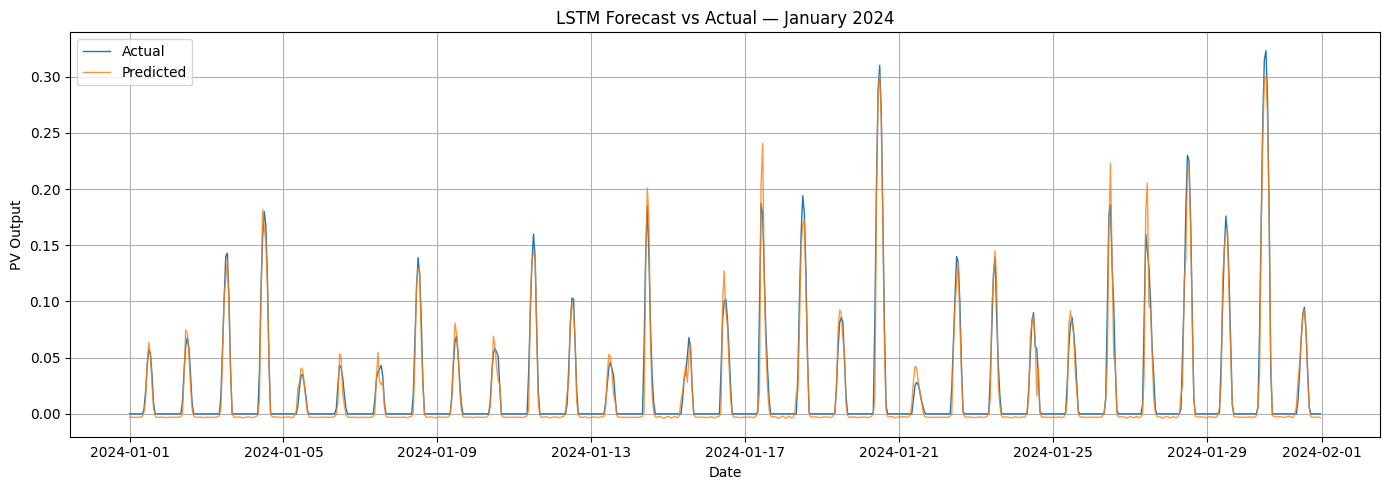

In [18]:
import calendar
jan = cmp[cmp.index.month == 1]

plt.figure(figsize=(14, 5))
plt.plot(jan.index, jan['Actual'], label='Actual', linewidth=1)
plt.plot(jan.index, jan['Predicted'], label='Predicted', alpha=0.8, linewidth=1)
plt.title('LSTM Forecast vs Actual — January 2024')
plt.xlabel('Date')
plt.ylabel('PV Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
df_daily = cmp.resample('D').sum(numeric_only=True)
df_daily

,Actual,Predicted
time,,
2024-01-01,0.222,0.154515
2024-01-02,0.282,0.213215
2024-01-03,0.604,0.504711
2024-01-04,0.817,0.730931
2024-01-05,0.144,0.127531
...,...,...
2024-12-27,0.559,0.463204
2024-12-28,0.163,0.126965
2024-12-29,0.426,0.342323


,Actual,Predicted
time,,
2024-01-01,0.222,0.154515
2024-01-02,0.282,0.213215
2024-01-03,0.604,0.504711
2024-01-04,0.817,0.730931
2024-01-05,0.144,0.127531
...,...,...
2024-12-27,0.559,0.463204
2024-12-28,0.163,0.126965
2024-12-29,0.426,0.342323


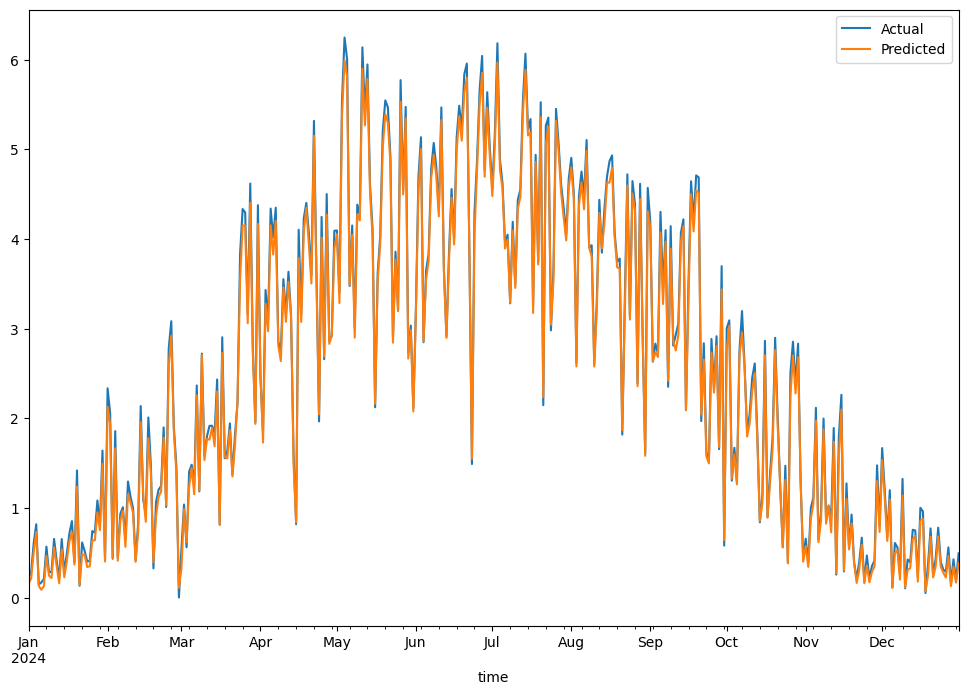

In [21]:
df_daily[['Actual','Predicted']].plot(figsize=(12,8))
df_daily

In [24]:
def rmse(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    return np.sqrt(mean_squared_error(a, b))

# Robust MAPE: ignore near-zero actuals to avoid blow-ups at night
def mape(a, b, eps=1e-3):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    mask = np.abs(a) > eps
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((a[mask] - b[mask]) / a[mask])) * 100

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
monthly = cmp.groupby([cmp.index.year, cmp.index.month]).apply(
    lambda g: pd.Series({
        'RMSE': rmse(g['Actual'], g['Predicted']),
        'MAE': mean_absolute_error(g['Actual'], g['Predicted']),
        'MAPE': mape(g['Actual'], g['Predicted'])
    })
)
print("\nMonthly metrics (year, month):\n", monthly)


Monthly metrics (year, month):
                RMSE       MAE       MAPE
time time                               
2024 1     0.009956  0.005748  33.600117
     2     0.014070  0.007961  36.024674
     3     0.015958  0.009457  26.962912
     4     0.014219  0.008790  17.718186
     5     0.012985  0.008434  12.450770
     6     0.011494  0.007757  12.390720
     7     0.012825  0.008301  12.093141
     8     0.013954  0.008373  14.650659
     9     0.017179  0.009693  19.251905
     10    0.014375  0.008114  35.371336
     11    0.011341  0.006181  35.005939
     12    0.008400  0.005310  59.974242
